# Capítulo 7 · Remedios y métodos robustos

**Objetivo:** aplicar y comparar distintos métodos para corregir o mitigar violaciones de supuestos en el modelo OLS:**

- Correcciones robustas a la heterocedasticidad (HC0–HC3).
- Modelos robustos `RLM` (Huber y Tukey).
- Estimación bootstrap de errores estándar e intervalos de confianza.

Al final construiremos tablas y **gráficas comparativas** entre métodos.


## 7.1 Datos y modelo base

Reutilizamos las **variables candidatas** seleccionadas en capítulos anteriores, usando el mismo criterio:

- Alta correlación con `SalePrice`.
- Baja colinealidad entre predictores (|ρ| ≤ 0.85).

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.robust.norms import HuberT, TukeyBiweight
from sklearn.utils import resample

# Localizar dataset
CANDIDATE_PATHS = [Path('data/ames_housing.csv'), Path('AmesHousing.csv')]
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError('No se encontró data/ames_housing.csv ni AmesHousing.csv')

df = pd.read_csv(DATA_PATH)

target = "SalePrice"

# Numéricas y limpieza de infinitos
num_df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Pool de variables según correlación absoluta con SalePrice
corr_abs = num_df.corr(numeric_only=True)[target].dropna().abs().sort_values(ascending=False)
pool = [c for c in corr_abs.index if c != target][:15]

sel = []
for v in pool:
    if not sel:
        sel.append(v)
        continue
    ok = True
    for u in sel:
        r = abs(num_df[[v, u]].dropna().corr().iloc[0, 1])
        if r > 0.85:
            ok = False
            break
    if ok:
        sel.append(v)
    if len(sel) >= 12:
        break

# Datos finales
data = num_df[[target] + sel].dropna()
y = data[target].values
X = sm.add_constant(data[sel].values, has_constant="add")

param_names = ["const"] + sel

len(sel), X.shape, y.shape

(12, (2748, 13), (2748,))

Mostramos las variables utilizadas en el modelo base:

In [3]:
pd.DataFrame({"Variable": sel, "abs(corr SalePrice)": corr_abs[sel].values}).round(3)

,Variable,abs(corr SalePrice)
0,Overall Qual,0.799
1,Gr Liv Area,0.707
2,Garage Cars,0.648
3,Total Bsmt SF,0.632
4,1st Flr SF,0.622
5,Year Built,0.558
6,Full Bath,0.546
7,Year Remod/Add,0.533
8,Garage Yr Blt,0.527
9,Mas Vnr Area,0.508


## 7.2 OLS clásico y evidencia de heterocedasticidad

Primero ajustamos el modelo OLS estándar y verificamos la presencia de heterocedasticidad con la prueba de **Breusch–Pagan**.


In [4]:
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     909.9
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:06:38   Log-Likelihood:                -32698.
No. Observations:                2748   AIC:                         6.542e+04
Df Residuals:                    2735   BIC:                         6.550e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.258e+06   9.42e+04    -13.357      0.0

In [5]:
# Prueba de Breusch–Pagan sobre residuos vs predictores
resid = ols.resid
bp_test = het_breuschpagan(resid, X)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
bp_results = pd.Series(bp_test, index=labels)
bp_results

LM stat        7.051415e+02
LM p-value    3.497135e-143
F stat         7.867089e+01
F p-value     3.561338e-166
dtype: float64

> Un p-valor pequeño sugiere **heterocedasticidad**, motivando el uso de correcciones robustas HC o modelos robustos.

## 7.3 Correcciones robustas HC0–HC3

Usamos `get_robustcov_results` para obtener errores estándar robustos a la heterocedasticidad:

- **HC0**: estimador de White.
- **HC1**: corrección por grados de libertad.
- **HC2**: pondera por leverage (puntos influyentes).
- **HC3**: aproximación tipo jackknife (más conservadora).

In [6]:
hc_types = ["HC0", "HC1", "HC2", "HC3"]
robust_results = {t: ols.get_robustcov_results(cov_type=t) for t in hc_types}

# Tabla de errores estándar por método
se_ols = ols.bse
se_hc = {t: robust_results[t].bse for t in hc_types}

se_df = pd.DataFrame(
    {"OLS": se_ols,
     "HC0": se_hc["HC0"],
     "HC1": se_hc["HC1"],
     "HC2": se_hc["HC2"],
     "HC3": se_hc["HC3"]},
    index=param_names,
).round(4)

se_df

,OLS,HC0,HC1,HC2,HC3
const,94166.7931,105742.5174,105993.5271,108198.0852,110801.8390
Overall Qual,812.2495,1324.2945,1327.4380,1366.6754,1411.5896
Gr Liv Area,3.0146,9.9259,9.9495,10.2729,10.6392
Garage Cars,1516.9382,2686.3687,2692.7456,2786.1600,2891.5570
Total Bsmt SF,2.8121,7.6867,7.7050,8.0225,8.3766
1st Flr SF,3.2118,4.3735,4.3839,4.4786,4.5890
Year Built,46.7429,39.7796,39.8740,40.0911,40.4068
Full Bath,1836.4550,3252.0103,3259.7299,3352.4205,3458.3813
Year Remod/Add,47.1037,37.2853,37.3738,37.5389,37.8000
Garage Yr Blt,55.9132,54.2226,54.3513,55.2492,56.3347


Podemos visualizar cómo cambian los errores estándar robustos respecto al OLS clásico:

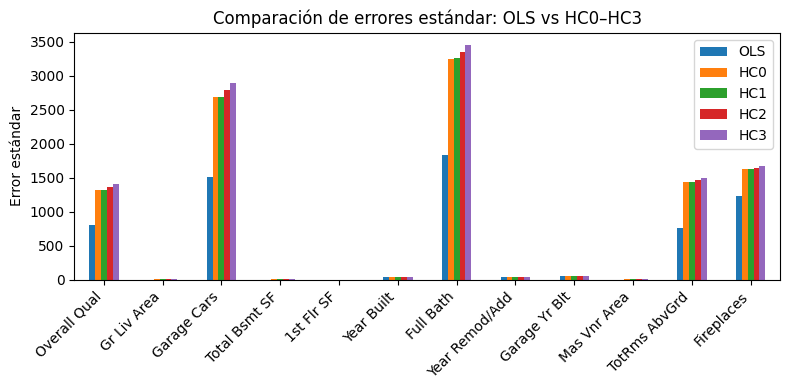

In [7]:
se_df_no_const = se_df.iloc[1:]  # sin intercepto para que la escala sea más comparable

ax = se_df_no_const.plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Error estándar")
ax.set_title("Comparación de errores estándar: OLS vs HC0–HC3")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 7.4 Modelos robustos RLM (Huber y Tukey)

Aplicamos `statsmodels.RLM` con dos funciones de pérdida robustas:

- **HuberT**: transición de cuadrático a lineal (suaviza outliers moderados).
- **TukeyBiweight**: reduce fuertemente la influencia de outliers extremos.

Compararemos los coeficientes con OLS.

In [8]:
rlm_huber = sm.RLM(y, X, M=HuberT()).fit()
rlm_tukey = sm.RLM(y, X, M=TukeyBiweight()).fit()

coef_rlm_df = pd.DataFrame(
    {
        "OLS": ols.params,
        "RLM_Huber": rlm_huber.params,
        "RLM_Tukey": rlm_tukey.params,
    },
    index=param_names,
).round(4)

coef_rlm_df

,OLS,RLM_Huber,RLM_Tukey
const,-1.257775e+06,-1.312490e+06,-1.313966e+06
Overall Qual,1.875345e+04,1.545312e+04,1.412857e+04
Gr Liv Area,4.918310e+01,5.709900e+01,5.544200e+01
Garage Cars,1.384683e+04,1.002649e+04,9.252621e+03
Total Bsmt SF,2.221390e+01,2.853620e+01,2.681220e+01
1st Flr SF,1.211340e+01,1.225610e+01,1.034860e+01
Year Built,2.164772e+02,2.510283e+02,2.836074e+02
Full Bath,-7.950185e+03,-1.027915e+04,-8.521765e+03
Year Remod/Add,3.763075e+02,3.588140e+02,3.490812e+02
Garage Yr Blt,1.192750e+01,3.177980e+01,1.703480e+01


Gráfico comparando los coeficientes (sin el intercepto para mejor escala):

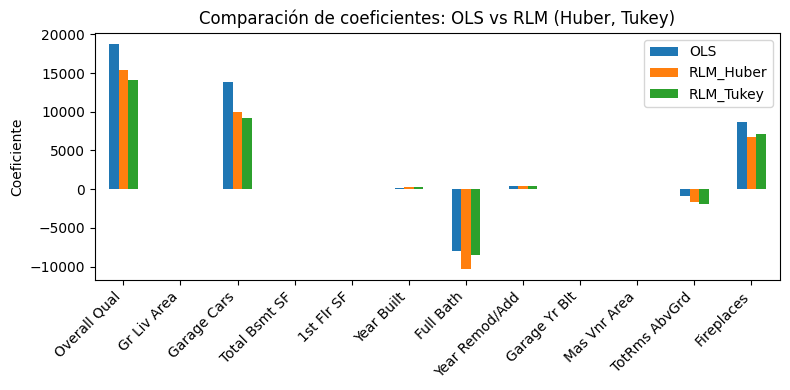

In [9]:
coef_rlm_no_const = coef_rlm_df.iloc[1:]

ax = coef_rlm_no_const.plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Coeficiente")
ax.set_title("Comparación de coeficientes: OLS vs RLM (Huber, Tukey)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 7.5 Bootstrap de coeficientes OLS

Implementamos un procedimiento bootstrap para los coeficientes del modelo OLS:

1. Fijar número de réplicas $B$ (por ejemplo, 1000).  
2. Para cada réplica:
   - Remuestrear las filas $(X, y)$ con reemplazo.
   - Ajustar el modelo OLS.  
   - Guardar los coeficientes.  
3. Calcular:
   - Error estándar bootstrap (desviación estándar de la distribución de coeficientes).  
   - Intervalos de confianza percentiles (2.5% y 97.5%).  


In [10]:
B = 1000  # puedes reducirlo (por ej. 300) si tarda mucho
n, k = X.shape
boot_betas = np.zeros((B, k))

for b in range(B):
    X_b, y_b = resample(X, y, replace=True, n_samples=n, random_state=None)
    beta_b = sm.OLS(y_b, X_b).fit().params
    boot_betas[b, :] = beta_b

boot_se = boot_betas.std(axis=0)
boot_ci_lower = np.percentile(boot_betas, 2.5, axis=0)
boot_ci_upper = np.percentile(boot_betas, 97.5, axis=0)

boot_table = pd.DataFrame(
    {
        "coef_OLS": ols.params,
        "SE_boot": boot_se,
        "IC_boot_2.5%": boot_ci_lower,
        "IC_boot_97.5%": boot_ci_upper,
    },
    index=param_names,
).round(4)

boot_table

,coef_OLS,SE_boot,IC_boot_2.5%,IC_boot_97.5%
const,-1.257775e+06,103229.4360,-1.460910e+06,-1.055539e+06
Overall Qual,1.875345e+04,1252.7474,1.624413e+04,2.111949e+04
Gr Liv Area,4.918310e+01,9.1936,3.261220e+01,6.689850e+01
Garage Cars,1.384683e+04,2529.1792,8.821913e+03,1.879206e+04
Total Bsmt SF,2.221390e+01,7.1604,9.184500e+00,3.571760e+01
1st Flr SF,1.211340e+01,4.3216,3.407300e+00,2.067340e+01
Year Built,2.164772e+02,39.6951,1.364376e+02,2.938859e+02
Full Bath,-7.950185e+03,3105.0779,-1.407705e+04,-1.979462e+03
Year Remod/Add,3.763075e+02,38.4743,3.003087e+02,4.524896e+02
Garage Yr Blt,1.192750e+01,52.5624,-8.408190e+01,1.145858e+02


Comparación de errores estándar OLS vs Bootstrap:

In [11]:
se_comp_boot = pd.DataFrame(
    {
        "SE_OLS": ols.bse,
        "SE_boot": boot_se,
    },
    index=param_names,
).round(4)

se_comp_boot

,SE_OLS,SE_boot
const,94166.7931,103229.4360
Overall Qual,812.2495,1252.7474
Gr Liv Area,3.0146,9.1936
Garage Cars,1516.9382,2529.1792
Total Bsmt SF,2.8121,7.1604
1st Flr SF,3.2118,4.3216
Year Built,46.7429,39.6951
Full Bath,1836.4550,3105.0779
Year Remod/Add,47.1037,38.4743
Garage Yr Blt,55.9132,52.5624


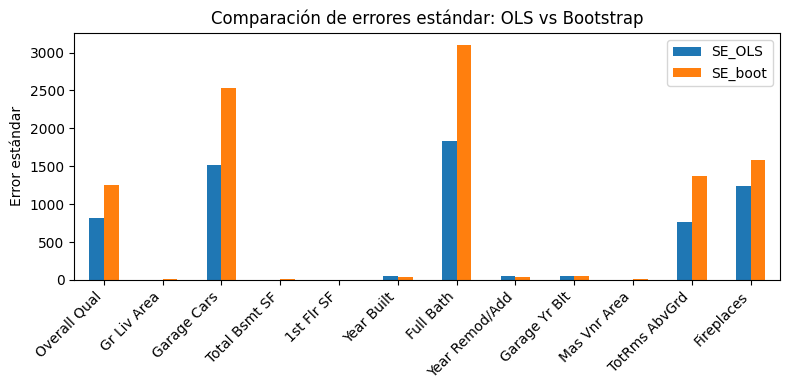

In [12]:
se_comp_boot_no_const = se_comp_boot.iloc[1:]

ax = se_comp_boot_no_const.plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Error estándar")
ax.set_title("Comparación de errores estándar: OLS vs Bootstrap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 7.6 Tabla comparativa final

Resumimos errores estándar para un subconjunto de métodos:

- OLS clásico
- HC3 (robusto a heterocedasticidad)
- Bootstrap
- RLM (Huber) – usando errores estándar de RLM


In [13]:
se_final = pd.DataFrame(
    {
        "SE_OLS": ols.bse,
        "SE_HC3": se_hc["HC3"],
        "SE_boot": boot_se,
        "SE_RLM_Huber": rlm_huber.bse,
    },
    index=param_names,
).round(4)

se_final

,SE_OLS,SE_HC3,SE_boot,SE_RLM_Huber
const,94166.7931,110801.8390,103229.4360,67588.1693
Overall Qual,812.2495,1411.5896,1252.7474,582.9917
Gr Liv Area,3.0146,10.6392,9.1936,2.1638
Garage Cars,1516.9382,2891.5570,2529.1792,1088.7817
Total Bsmt SF,2.8121,8.3766,7.1604,2.0184
1st Flr SF,3.2118,4.5890,4.3216,2.3052
Year Built,46.7429,40.4068,39.6951,33.5497
Full Bath,1836.4550,3458.3813,3105.0779,1318.1147
Year Remod/Add,47.1037,37.8000,38.4743,33.8086
Garage Yr Blt,55.9132,56.3347,52.5624,40.1316


## 7.7 Key takeaways

- Las correcciones **HC0–HC3** ajustan los errores estándar sin cambiar los coeficientes OLS.  
- **HC3** suele recomendarse con tamaños de muestra moderados, al ser más conservadora.  
- Los modelos **RLM (Huber, Tukey)** modifican tanto coeficientes como errores estándar, reduciendo la influencia de outliers.  
- El **Bootstrap** proporciona errores estándar e intervalos de confianza sin depender fuertemente de supuestos de normalidad.  
- La comparación de métodos ayuda a elegir un enfoque robusto cuando se detectan violaciones relevantes de los supuestos OLS clásicos.

Este capítulo cierra el bloque de **remedios robustos**, preparando el camino para la **regularización (Ridge, Lasso, ElasticNet)** en los siguientes capítulos.
